## Data Description

- Item_Identifier: Unique product ID

- Item_Weight: Weight of product

- Item_Fat_Content: Whether the product is low fat or not

- Item_Visibility: The % of total display area of all products in a store allocated to the particular product

- Item_Type: The category to which the product belongs

- Item_MRP: Maximum Retail Price (list price) of the product

- Outlet_Identifier: Unique store ID

- Outlet_Establishment_Year: The year in which store was established

- Outlet_Size: The size of the store in terms of ground area covered

- Outlet_Location_Type: The type of city in which the store is located

- Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket

- Item_Outlet_Sales: Sales of the product in the particulat store. This is the outcome variable to be predicted.

In [1]:
import time
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

In [2]:
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler

In [3]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train_df = pd.read_csv("train_av.csv")

In [6]:
train_df.shape

(8523, 12)

In [7]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [9]:
test_df = pd.read_csv("test_av.csv")

In [10]:
test_df.shape

(5681, 11)

In [11]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [12]:
#Checking the memory usage of both dataframes

print("Train set: {:2.2f} Mb".format(train_df.memory_usage().sum() / 1024**2))
print("Test set: {:2.2f} Mb".format(test_df.memory_usage().sum() / 1024**2))

Train set: 0.78 Mb
Test set: 0.48 Mb


These dataframes are small and their memory usage does not have to be reduced.

## Handling Missing Values

In [13]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


Only the Item_Weight and Outlet_Size columns have missing values. Let's check if they can be derived from the other columns.

In [15]:
#Creating a boolean series with True for every null value in the Item_Weight column
bool_ItemWeight = pd.isnull(train_df['Item_Weight'])

#Viewing the Item_Identifier and Item_Weight columns where the Item_Weight is null
train_df[['Item_Identifier', 'Item_Weight']][bool_ItemWeight]

,Item_Identifier,Item_Weight
7,FDP10,NaN
18,DRI11,NaN
21,FDW12,NaN
23,FDC37,NaN
29,FDC14,NaN
...,...,...
8485,DRK37,NaN
8487,DRG13,NaN
8488,NCN14,NaN
8490,FDU44,NaN


In [16]:
#Grouping the train dataframe by the Item_Identifier column
item_groupby = train_df.groupby(['Item_Identifier'])

In [17]:
#Checking the Item_Weight values for the Item_Identifier value 'DRI11'
item_groupby.get_group('DRI11')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
1366,DRI11,NaN,Low Fat,0.060237,Hard Drinks,115.9834,OUT019,1985,Small,Tier 1,Grocery Store,345.5502
3127,DRI11,8.26,Low Fat,0.034458,Hard Drinks,113.3834,OUT049,1999,Medium,Tier 1,Supermarket Type1,2073.3012
5310,DRI11,8.26,Low Fat,0.057586,Hard Drinks,113.7834,OUT010,1998,NaN,Tier 3,Grocery Store,115.1834
7022,DRI11,8.26,Low Fat,0.034398,Hard Drinks,115.7834,OUT035,2004,Small,Tier 2,Supermarket Type1,2073.3012
7192,DRI11,8.26,Low Fat,0.034544,Hard Drinks,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,1267.0174
8483,DRI11,8.26,Low Fat,0.034474,Hard Drinks,117.0834,OUT045,2002,NaN,Tier 2,Supermarket Type1,1612.5676


As expected, we can get item weights from the item identifier column. But we need to check that the item weight is constant for a given item before imputing them in the null values.

In [18]:
#Checking the number of unique item types
train_df['Item_Identifier'].describe()

count      8523
unique     1559
top       FDG33
freq         10
Name: Item_Identifier, dtype: object

Since the number of unique items is very high, it's not possible to manually check item weights for each item. Let's create a mapping of item identifiers and item weights.

In [19]:
#Creating a list of items that have atleast one null value in the item weight column
null_items_list = list(set(train_df['Item_Identifier'][bool_ItemWeight]))
len(null_items_list)

1142

Next, identifying the rows that don't have null values, so that their item weights can be checked.

In [20]:
#Creating a boolean series with True for every non-null value in the Item_Weight column
bool_ItemWeight_notnull = pd.notnull(train_df['Item_Weight'])

In [21]:
#This piece of code displays the values in column 'Item_Weight' for the specified values in column 'Item_Identifier'
train_df[bool_ItemWeight_notnull].loc[train_df['Item_Identifier']=='FDP10', 'Item_Weight']

585     19.0
2623    19.0
3382    19.0
4585    19.0
6087    19.0
7883    19.0
Name: Item_Weight, dtype: float64

In [22]:
#Checking that the item weight is the same for all values of the specified item
len(set(train_df[bool_ItemWeight_notnull].loc[train_df['Item_Identifier']=='FDP10', 'Item_Weight']))

1

In [23]:
train_df_backup = train_df.copy()
test_df_backup = test_df.copy()
print("Train shape: ", train_df_backup.shape)
print("Test shape: ", test_df_backup.shape)

Train shape:  (8523, 12)
Test shape:  (5681, 11)


In [24]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [27]:
#Creating a group by object, in order to get the mode
grouped_ItemIdentifier = train_df.groupby('Item_Identifier')

In [28]:
#Let's view the Item_Weight column for all the item identifiers in the groupby object
for key, item in grouped_ItemIdentifier:
    print(grouped_ItemIdentifier['Item_Weight'].get_group(key), "\n\n")

118     11.6
1197    11.6
1245    11.6
1693    11.6
7467    11.6
8043    11.6
Name: Item_Weight, dtype: float64 


1148    19.35
2879      NaN
4130    19.35
4416      NaN
4900    19.35
6863    19.35
8195    19.35
Name: Item_Weight, dtype: float64 


1876    8.27
3927    8.27
3962    8.27
5609    8.27
6057     NaN
6179     NaN
6338    8.27
8371    8.27
Name: Item_Weight, dtype: float64 


3465    7.39
3571    7.39
3733     NaN
Name: Item_Weight, dtype: float64 


1431    6.115
1836    6.115
2479    6.115
4135    6.115
6626    6.115
Name: Item_Weight, dtype: float64 


2657    8.785
6128    8.785
7619    8.785
7811    8.785
Name: Item_Weight, dtype: float64 


776     12.3
2533     NaN
3161    12.3
6058    12.3
8063    12.3
8289    12.3
Name: Item_Weight, dtype: float64 


103     16.75
458       NaN
576     16.75
1918    16.75
2944    16.75
5627    16.75
8106    16.75
Name: Item_Weight, dtype: float64 


1       5.92
2272    5.92
2927     NaN
5029    5.92
5077    5.92
5218    5.92
Name:

Name: Item_Weight, dtype: float64 


509      NaN
1147    15.2
3116    15.2
4949     NaN
8156    15.2
Name: Item_Weight, dtype: float64 


3103    9.6
3356    9.6
5786    9.6
6183    9.6
7473    9.6
7599    9.6
Name: Item_Weight, dtype: float64 


360     12.1
746     12.1
1762    12.1
2676    12.1
3550     NaN
3672    12.1
6900    12.1
7434    12.1
8100    12.1
Name: Item_Weight, dtype: float64 


1381    15.0
2811    15.0
4759     NaN
7138    15.0
Name: Item_Weight, dtype: float64 


1471    13.85
1956    13.85
4526    13.85
6649    13.85
Name: Item_Weight, dtype: float64 


2146    10.195
2813    10.195
3751    10.195
4003    10.195
4503    10.195
8414    10.195
Name: Item_Weight, dtype: float64 


3188    11.8
3587    11.8
6811     NaN
7084    11.8
Name: Item_Weight, dtype: float64 


409       NaN
820     18.85
1701      NaN
3270    18.85
3988    18.85
4356    18.85
5291    18.85
7957    18.85
Name: Item_Weight, dtype: float64 


305     15.75
3184    15.75
4106    15.75
6932    1

Name: Item_Weight, dtype: float64 


757     18.85
1347    18.85
1594      NaN
2617    18.85
4168    18.85
5643    18.85
5965    18.85
Name: Item_Weight, dtype: float64 


886     11.15
1652    11.15
2018    11.15
5162      NaN
6953      NaN
7307    11.15
Name: Item_Weight, dtype: float64 


1371    18.25
1579      NaN
1646    18.25
3520    18.25
4914    18.25
7642    18.25
Name: Item_Weight, dtype: float64 


1857    16.2
3689     NaN
4705     NaN
4955    16.2
7605    16.2
Name: Item_Weight, dtype: float64 


2205    15.2
2527    15.2
3878    15.2
4380    15.2
7361    15.2
7507    15.2
Name: Item_Weight, dtype: float64 


1399    18.1
1516    18.1
3366     NaN
4226    18.1
5277    18.1
6586    18.1
7263    18.1
Name: Item_Weight, dtype: float64 


80      7.76
681     7.76
6701    7.76
7003     NaN
7177    7.76
7950    7.76
Name: Item_Weight, dtype: float64 


963     10.5
1936    10.5
3249     NaN
5001    10.5
Name: Item_Weight, dtype: float64 


789     8.71
4176    8.71
4882    8.7

Name: Item_Weight, dtype: float64 


979     9.3
1505    9.3
1532    9.3
1842    9.3
3674    NaN
4697    9.3
6002    9.3
7729    9.3
8030    NaN
Name: Item_Weight, dtype: float64 


648     20.75
1126    20.75
4417    20.75
8517    20.75
Name: Item_Weight, dtype: float64 


1509    16.7
1787    16.7
2404    16.7
4998    16.7
5784    16.7
5799     NaN
6535    16.7
7968    16.7
8292     NaN
Name: Item_Weight, dtype: float64 


1217    14.5
2693     NaN
3616    14.5
4189    14.5
5417    14.5
5728     NaN
6730    14.5
Name: Item_Weight, dtype: float64 


3163    13.3
4148     NaN
7354    13.3
Name: Item_Weight, dtype: float64 


3530    12.5
5667    12.5
6496    12.5
7145    12.5
Name: Item_Weight, dtype: float64 


73      7.855
134     7.855
1606    7.855
2557      NaN
8449      NaN
Name: Item_Weight, dtype: float64 


4147     NaN
6563    13.1
7483    13.1
7727    13.1
Name: Item_Weight, dtype: float64 


3994     NaN
4073    11.0
5041    11.0
7749    11.0
Name: Item_Weight, dtype: floa

Name: Item_Weight, dtype: float64 


260     12.8
686     12.8
964     12.8
1380    12.8
1539    12.8
1749    12.8
2466    12.8
2615     NaN
Name: Item_Weight, dtype: float64 


359       NaN
1805      NaN
2938    8.985
4301    8.985
4425    8.985
Name: Item_Weight, dtype: float64 


866     7.42
1401    7.42
2767    7.42
6814     NaN
7418    7.42
8423    7.42
8496    7.42
Name: Item_Weight, dtype: float64 


70      15.6
1732    15.6
1775    15.6
5450     NaN
6317    15.6
6685    15.6
6775     NaN
8083    15.6
Name: Item_Weight, dtype: float64 


872     19.35
2805    19.35
6757    19.35
7321    19.35
7621    19.35
8169    19.35
Name: Item_Weight, dtype: float64 


865     12.5
1476    12.5
2177     NaN
4644    12.5
7679    12.5
8313    12.5
Name: Item_Weight, dtype: float64 


1696    12.6
2429    12.6
3049    12.6
3286     NaN
3324    12.6
4961    12.6
7708    12.6
Name: Item_Weight, dtype: float64 


2850    7.36
3178    7.36
3563    7.36
4721     NaN
4940    7.36
Name: Item_Weight

Name: Item_Weight, dtype: float64 


81      11.8
1142     NaN
2105    11.8
2729    11.8
2845    11.8
3653    11.8
4157    11.8
Name: Item_Weight, dtype: float64 


1921    7.72
3472    7.72
3945     NaN
6322    7.72
8439    7.72
Name: Item_Weight, dtype: float64 


493     14.15
1953    14.15
1985    14.15
4495      NaN
4765    14.15
8113    14.15
Name: Item_Weight, dtype: float64 


1391    11.5
2666    11.5
4537     NaN
6873    11.5
7672    11.5
Name: Item_Weight, dtype: float64 


805      NaN
1346    15.6
3086    15.6
3581    15.6
5846    15.6
6302    15.6
6700    15.6
Name: Item_Weight, dtype: float64 


157     18.6
1492    18.6
3767     NaN
4758    18.6
6758    18.6
8317    18.6
Name: Item_Weight, dtype: float64 


2       17.5
759     17.5
4817    17.5
5074    17.5
6163    17.5
6952     NaN
8349     NaN
Name: Item_Weight, dtype: float64 


530     12.6
1031    12.6
2030    12.6
2093    12.6
4970    12.6
Name: Item_Weight, dtype: float64 


718     19.35
1478      NaN
5412    1

Name: Item_Weight, dtype: float64 


84       NaN
1887     NaN
2032    12.6
3078    12.6
6347    12.6
6561    12.6
Name: Item_Weight, dtype: float64 


52      9.895
1128    9.895
5648    9.895
Name: Item_Weight, dtype: float64 


956     11.65
5150      NaN
5738      NaN
5907    11.65
8266    11.65
Name: Item_Weight, dtype: float64 


2355    9.3
4263    NaN
4351    9.3
5956    9.3
6073    9.3
6680    NaN
7712    9.3
Name: Item_Weight, dtype: float64 


676     5.845
7684    5.845
7967    5.845
Name: Item_Weight, dtype: float64 


893     13.5
3196    13.5
3291    13.5
5642     NaN
5895    13.5
8035    13.5
Name: Item_Weight, dtype: float64 


650     20.0
975     20.0
2240    20.0
3212    20.0
4332    20.0
8486    20.0
Name: Item_Weight, dtype: float64 


484     19.7
4364    19.7
4918    19.7
6375     NaN
6477    19.7
6805    19.7
6887    19.7
Name: Item_Weight, dtype: float64 


4311    19.35
5600    19.35
6515    19.35
7168    19.35
7528    19.35
7902      NaN
8192    19.35
Name: 

Name: Item_Weight, dtype: float64 


768     9.5
955     9.5
2378    NaN
2858    9.5
3651    9.5
Name: Item_Weight, dtype: float64 


1681    7.35
2901     NaN
4602    7.35
7537    7.35
Name: Item_Weight, dtype: float64 


2239     NaN
2290    12.1
3417    12.1
4845    12.1
4846    12.1
6297    12.1
7017    12.1
8299    12.1
Name: Item_Weight, dtype: float64 


26      7.645
2289    7.645
5094    7.645
5652    7.645
6871      NaN
Name: Item_Weight, dtype: float64 


114     9.1
3813    9.1
3845    9.1
4038    9.1
Name: Item_Weight, dtype: float64 


839     16.7
3841    16.7
5518    16.7
6500    16.7
Name: Item_Weight, dtype: float64 


300       NaN
6001    17.35
6755    17.35
8489    17.35
Name: Item_Weight, dtype: float64 


3182    19.85
5306    19.85
6524    19.85
Name: Item_Weight, dtype: float64 


190     10.3
3884     NaN
5200    10.3
5679     NaN
7375    10.3
8391    10.3
Name: Item_Weight, dtype: float64 


2086    7.75
2668    7.75
2756    7.75
2844    7.75
3394    7.75
534

Name: Item_Weight, dtype: float64 


552      NaN
1302    13.1
2197    13.1
4579    13.1
6457    13.1
6981    13.1
7392    13.1
Name: Item_Weight, dtype: float64 


164     6.155
2100    6.155
3012    6.155
6169      NaN
7079    6.155
7154    6.155
Name: Item_Weight, dtype: float64 


2880    14.0
3738    14.0
5194     NaN
6594    14.0
Name: Item_Weight, dtype: float64 


1523     NaN
5463    12.6
6437    12.6
6809    12.6
7942    12.6
Name: Item_Weight, dtype: float64 


982     7.68
1859     NaN
2002    7.68
4331    7.68
4543    7.68
5593    7.68
Name: Item_Weight, dtype: float64 


102     8.31
1769    8.31
2471    8.31
6359    8.31
7433    8.31
Name: Item_Weight, dtype: float64 


2991    20.75
8014    20.75
Name: Item_Weight, dtype: float64 


2715      NaN
5822    13.15
6224    13.15
6720    13.15
8334    13.15
8413    13.15
Name: Item_Weight, dtype: float64 


2673    5.44
7491    5.44
8175     NaN
Name: Item_Weight, dtype: float64 


1955    10.1
4547    10.1
5546     NaN
5696 

Name: Item_Weight, dtype: float64 


942     19.7
992     19.7
4251    19.7
4811    19.7
5498    19.7
6361     NaN
Name: Item_Weight, dtype: float64 


1672      NaN
2707    8.935
5309    8.935
5971    8.935
7443    8.935
Name: Item_Weight, dtype: float64 


1998     NaN
3297    11.0
3861    11.0
4150    11.0
6137    11.0
Name: Item_Weight, dtype: float64 


1001    8.185
3293      NaN
3463    8.185
4117    8.185
4212    8.185
7821    8.185
Name: Item_Weight, dtype: float64 


1824    14.1
2102     NaN
2515    14.1
2763    14.1
5533    14.1
7114    14.1
Name: Item_Weight, dtype: float64 


117     7.485
6061    7.485
6216    7.485
7445    7.485
Name: Item_Weight, dtype: float64 


518      NaN
1186    20.7
2397    20.7
4082    20.7
6773    20.7
Name: Item_Weight, dtype: float64 


1403    17.75
3354      NaN
3358    17.75
4895    17.75
5362    17.75
5702    17.75
Name: Item_Weight, dtype: float64 


1495    11.0
1679    11.0
5016    11.0
6763     NaN
7110    11.0
8412    11.0
Name: Ite

Name: Item_Weight, dtype: float64 


823     15.2
1445     NaN
2130    15.2
2491    15.2
2500     NaN
2774    15.2
5949    15.2
7918    15.2
8494    15.2
Name: Item_Weight, dtype: float64 


2783    18.6
6052    18.6
6290    18.6
6414    18.6
7380     NaN
Name: Item_Weight, dtype: float64 


2326     NaN
2455    18.7
3743    18.7
4596    18.7
5576    18.7
7111    18.7
Name: Item_Weight, dtype: float64 


4020     NaN
4057    20.1
5938    20.1
6991    20.1
Name: Item_Weight, dtype: float64 


1496    7.68
6458    7.68
6851    7.68
7048    7.68
7452    7.68
Name: Item_Weight, dtype: float64 


443     12.35
1216    12.35
1697    12.35
1841    12.35
1963    12.35
7049      NaN
7303    12.35
Name: Item_Weight, dtype: float64 


3871    18.6
5055    18.6
5057    18.6
5070     NaN
8516    18.6
Name: Item_Weight, dtype: float64 


401     10.6
793      NaN
1422    10.6
4186    10.6
5902    10.6
8520    10.6
Name: Item_Weight, dtype: float64 


594     5.82
806     5.82
1116    5.82
1480    5.

Name: Item_Weight, dtype: float64 


1670     NaN
2412    13.0
3092    13.0
3798    13.0
5764    13.0
6156    13.0
7339    13.0
7895    13.0
8329     NaN
Name: Item_Weight, dtype: float64 


4398    10.3
5482    10.3
5636    10.3
7740     NaN
Name: Item_Weight, dtype: float64 


2679    15.75
4055      NaN
7100    15.75
7454    15.75
Name: Item_Weight, dtype: float64 


2779    12.0
3890    12.0
6424     NaN
Name: Item_Weight, dtype: float64 


3810    7.725
4472      NaN
5579    7.725
6074    7.725
8456    7.725
Name: Item_Weight, dtype: float64 


717     16.35
1289    16.35
2167    16.35
4727    16.35
4762    16.35
5604      NaN
5618    16.35
Name: Item_Weight, dtype: float64 


612     14.8
1329     NaN
3639    14.8
5502    14.8
8315    14.8
Name: Item_Weight, dtype: float64 


622     20.35
744     20.35
1976      NaN
3334    20.35
5420      NaN
8500    20.35
Name: Item_Weight, dtype: float64 


556       NaN
2792    17.75
3918    17.75
4244    17.75
4405    17.75
4830    17.75
54

Name: Item_Weight, dtype: float64 


1874    8.43
3662    8.43
5924    8.43
7002     NaN
Name: Item_Weight, dtype: float64 


1208    8.485
3244    8.485
7873      NaN
Name: Item_Weight, dtype: float64 


698      NaN
790     19.6
1331    19.6
1900    19.6
3613     NaN
4625    19.6
5357    19.6
Name: Item_Weight, dtype: float64 


1397      NaN
2872    12.15
4280    12.15
6716    12.15
7265    12.15
7832    12.15
Name: Item_Weight, dtype: float64 


74      7.825
281     7.825
1087    7.825
3750      NaN
3863    7.825
7839    7.825
7905    7.825
Name: Item_Weight, dtype: float64 


3468    15.0
4528    15.0
7108    15.0
8054    15.0
Name: Item_Weight, dtype: float64 


1224    6.59
2428    6.59
3220    6.59
3739    6.59
4418    6.59
4523     NaN
7068    6.59
Name: Item_Weight, dtype: float64 


922     19.85
5119    19.85
5271    19.85
6744    19.85
6965    19.85
Name: Item_Weight, dtype: float64 


411     10.5
1115    10.5
3775    10.5
6056    10.5
6488    10.5
Name: Item_Weight, dty

The item weight for each item appears to be the same. Some of the entries are null values. Therefore, we can impute the mode item weight for each item in place of the null values.

In [29]:
#Making a list of item identifiers in the train set
itemIdentifier_list = list(train_df['Item_Identifier'].unique())

Next, let's map each item to its item weight.

In [30]:
dict_itemIdentifier_mode = {}

#Creating a dictionary that contains the item weight mode value for each item identifier
for i in itemIdentifier_list:
    dict_itemIdentifier_mode[i] = statistics.mode(grouped_ItemIdentifier['Item_Weight'].get_group(i))

Note: statistics.mode() returns just the mode value, whereas the vanilla mode() function returns an object that is not as easy to handle.

In [31]:
#Triggering garbage collection
gc.collect()

60

In [32]:
#Imputing the mode value of the Item Weight (for the corresponding Item Identifier) wherever Item_Weight is null
train_df['Item_Weight'] = train_df.apply(lambda x: dict_itemIdentifier_mode[x['Item_Identifier']] if (pd.isnull(x['Item_Weight'])) else x['Item_Weight'], axis=1)

In [33]:
#Repeating the same imputation step in the test set
test_df['Item_Weight'] = test_df.apply(lambda x: dict_itemIdentifier_mode[x['Item_Identifier']] if (pd.isnull(x['Item_Weight'])) else x['Item_Weight'], axis=1)

Note that the mode was calculated using only the train set. This value has been used for imputation in the test set.

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8512 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Let's check the rows that still have null values in the Item_Weight column.

In [35]:
#Checking for null values in the Item_Weight column
bool_ItemWeight_new = pd.isnull(train_df['Item_Weight'])

#Listing the identifier values where Item_Weight is null
list_itemIdentifier = list(set(train_df['Item_Identifier'][bool_ItemWeight_new]))
list_itemIdentifier

['FDE38',
 'FDN52',
 'FDZ50',
 'FDK57',
 'FDE52',
 'NCT53',
 'FDQ60',
 'FDH52',
 'FDU43']

Checking the mode values (of the item weight column) for these item identifiers in the group by object

In [36]:
for i in list_itemIdentifier:
    print("Identifier: ", i)
    print(grouped_ItemIdentifier['Item_Weight'].get_group(i), "\n\n")

Identifier:  FDE38
739      NaN
6113    6.52
Name: Item_Weight, dtype: float64 


Identifier:  FDN52
927   NaN
Name: Item_Weight, dtype: float64 


Identifier:  FDZ50
1467     NaN
6227    12.8
Name: Item_Weight, dtype: float64 


Identifier:  FDK57
1922   NaN
Name: Item_Weight, dtype: float64 


Identifier:  FDE52
4187   NaN
Name: Item_Weight, dtype: float64 


Identifier:  NCT53
4734    NaN
7387    NaN
8471    5.4
Name: Item_Weight, dtype: float64 


Identifier:  FDQ60
5022   NaN
Name: Item_Weight, dtype: float64 


Identifier:  FDH52
1932     NaN
3864     NaN
5228    9.42
Name: Item_Weight, dtype: float64 


Identifier:  FDU43
6526      NaN
7421    19.35
Name: Item_Weight, dtype: float64 




Some of these item identifiers do contain valid entries in the item weight column that can be used for imputation (but these entries were probably not sufficient to calculate the mode).

In [37]:
dict_itemIdentifier_mode_new = {'FDU43': 19.35, 'FDZ50': 12.8, 'FDH52': 9.42, 'NCT53': 5.4, 'FDE38': 6.52}

list(dict_itemIdentifier_mode_new.keys())

['FDU43', 'FDZ50', 'FDH52', 'NCT53', 'FDE38']

In [38]:
dict_itemIdentifier_mode_new = {'FDU43': 19.35, 'FDZ50': 12.8, 'FDH52': 9.42, 'NCT53': 5.4, 'FDE38': 6.52}

#Imputing these values in the train set
train_df['Item_Weight'] = train_df.apply(lambda x: dict_itemIdentifier_mode_new[x['Item_Identifier']] 
                                         if ((x['Item_Identifier'] in list(dict_itemIdentifier_mode_new.keys())) & (pd.isnull(x['Item_Weight']))) 
                                         else x['Item_Weight'], axis=1)

In [39]:
#Imputing the same values in the test set
test_df['Item_Weight'] = test_df.apply(lambda x: dict_itemIdentifier_mode_new[x['Item_Identifier']] 
                                         if ((x['Item_Identifier'] in list(dict_itemIdentifier_mode_new.keys())) & (pd.isnull(x['Item_Weight']))) 
                                         else x['Item_Weight'], axis=1)

In [40]:
#Checking for null values in the Item_Weight column again
bool_ItemWeight_new = pd.isnull(train_df['Item_Weight'])

#Listing the identifier values where Item_Weight is null
list_itemIdentifier = list(set(train_df['Item_Identifier'][bool_ItemWeight_new]))
list_itemIdentifier

['FDQ60', 'FDK57', 'FDN52', 'FDE52']

These item weights are not present in the train set. Checking if they are present in the test set.

In [41]:
#Viewing the rows with the specified item identifier
print("FDN52: ",test_df.loc[test_df['Item_Identifier']=='FDN52', 'Item_Weight'])
print("FDK57: ",test_df.loc[test_df['Item_Identifier']=='FDK57', 'Item_Weight'])
print("FDE52: ",test_df.loc[test_df['Item_Identifier']=='FDE52', 'Item_Weight'])
print("FDQ60: ",test_df.loc[test_df['Item_Identifier']=='FDQ60', 'Item_Weight'])

FDN52:  396     9.395
1547    9.395
2963    9.395
3070    9.395
3171    9.395
3579    9.395
4252    9.395
5271    9.395
Name: Item_Weight, dtype: float64
FDK57:  1163    10.195
1501    10.195
1576    10.195
1793    10.195
2438    10.195
4297    10.195
4806    10.195
4942    10.195
Name: Item_Weight, dtype: float64
FDE52:  59      10.395
144     10.395
502     10.395
1081    10.395
1980    10.395
5196    10.395
5221    10.395
Name: Item_Weight, dtype: float64
FDQ60:  440     6.195
1059    6.195
1713    6.195
1724      NaN
2044    6.195
4154    6.195
4524    6.195
5535    6.195
Name: Item_Weight, dtype: float64


These weights (from the test set) can be imputed in the train set.

In [42]:
weights_in_test = ['FDN52', 'FDK57', 'FDE52', 'FDQ60']

#Finding the rows where the weight is not null in the test set
bool_IW_notnull_test = pd.notnull(test_df['Item_Weight'])

#Looping through this list
for i in weights_in_test:
        
    #Getting the number of unique weight values for this item
    check_weights = len(set(test_df[bool_IW_notnull_test].loc[test_df['Item_Identifier']==i, 'Item_Weight']))
    
    #Checking if the available item weights are the same for the item
    if check_weights==1:
        
        #Getting the item weight
        item_weight = list(set(test_df[bool_IW_notnull_test].loc[test_df['Item_Identifier']==i, 'Item_Weight']))
        
        #Imputing this weight in the train and test sets
        train_df.loc[train_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]
        test_df.loc[test_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [44]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                5681 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


The missing values in the Item_Weight column have been imputed in both the train and test sets. Next, checking the Outlet_Size column in the train set.

In [45]:
#Checking for non-null values in the Outlet_Size column
bool_OS_notnull = pd.notnull(train_df['Outlet_Size'])

#Viewing the outlet size and outlet type columns where Outlet_Size is null
train_df[['Outlet_Size', 'Outlet_Type', 'Outlet_Identifier']][bool_OS_notnull]

,Outlet_Size,Outlet_Type,Outlet_Identifier
0,Medium,Supermarket Type1,OUT049
1,Medium,Supermarket Type2,OUT018
2,Medium,Supermarket Type1,OUT049
4,High,Supermarket Type1,OUT013
5,Medium,Supermarket Type2,OUT018
...,...,...,...
8517,Small,Supermarket Type1,OUT046
8518,High,Supermarket Type1,OUT013
8520,Small,Supermarket Type1,OUT035
8521,Medium,Supermarket Type2,OUT018


It looks like Outlet_Size can be obtained from Outlet_Identifier.

In [46]:
#Checking the number of outlets
train_df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT035    930
OUT046    930
OUT049    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [47]:
#Checking the number of outlets in the test set
test_df['Outlet_Identifier'].value_counts()

OUT027    624
OUT013    621
OUT035    620
OUT046    620
OUT049    620
OUT045    619
OUT018    618
OUT017    617
OUT010    370
OUT019    352
Name: Outlet_Identifier, dtype: int64

The same outlets are present in both train and test sets.

In [48]:
#Creating a list of outlet identifiers

outlet_identifiers_list = list(set(train_df['Outlet_Identifier']))
len(outlet_identifiers_list)

10

In [49]:
#Checking if there is at least one valid entry in the Outlet_Size column for each outlet
for i in outlet_identifiers_list:
    print("Outlet: ", i)
    print("Outlet Size: ", train_df[bool_OS_notnull].loc[train_df['Outlet_Identifier']==i, 'Outlet_Size'])
    print("\n")

Outlet:  OUT018
Outlet Size:  1       Medium
5       Medium
16      Medium
31      Medium
32      Medium
         ...  
8506    Medium
8511    Medium
8515    Medium
8516    Medium
8521    Medium
Name: Outlet_Size, Length: 928, dtype: object


Outlet:  OUT017
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT035
Outlet Size:  19      Small
22      Small
26      Small
66      Small
86      Small
        ...  
8503    Small
8507    Small
8510    Small
8513    Small
8520    Small
Name: Outlet_Size, Length: 930, dtype: object


Outlet:  OUT049
Outlet Size:  0       Medium
2       Medium
10      Medium
12      Medium
17      Medium
         ...  
8451    Medium
8467    Medium
8470    Medium
8475    Medium
8479    Medium
Name: Outlet_Size, Length: 930, dtype: object


Outlet:  OUT019
Outlet Size:  23      Small
29      Small
49      Small
59      Small
63      Small
        ...  
8454    Small
8458    Small
8469    Small
8480    Small
8490    Small
Name: Outlet_Size, Le

The outlet size is not available for the following outlets in the train set: OUT010, OUT045, and OUT017. Let's check if they are available in the test set.

In [50]:
#Checking if there is at least one valid entry in the Outlet_Size column for each outlet in the test set

bool_OS_notnull_test = pd.notnull(test_df['Outlet_Size'])

for i in outlet_identifiers_list:
    print("Outlet: ", i)
    print("Outlet Size: ", test_df[bool_OS_notnull_test].loc[test_df['Outlet_Identifier']==i, 'Outlet_Size'])
    print("\n")

Outlet:  OUT018
Outlet Size:  6       Medium
17      Medium
31      Medium
32      Medium
40      Medium
         ...  
5636    Medium
5663    Medium
5664    Medium
5673    Medium
5677    Medium
Name: Outlet_Size, Length: 618, dtype: object


Outlet:  OUT017
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT035
Outlet Size:  21      Small
24      Small
26      Small
29      Small
47      Small
        ...  
5550    Small
5575    Small
5614    Small
5629    Small
5653    Small
Name: Outlet_Size, Length: 620, dtype: object


Outlet:  OUT049
Outlet Size:  0       Medium
13      Medium
15      Medium
55      Medium
70      Medium
         ...  
5646    Medium
5659    Medium
5671    Medium
5672    Medium
5675    Medium
Name: Outlet_Size, Length: 620, dtype: object


Outlet:  OUT019
Outlet Size:  12      Small
23      Small
30      Small
58      Small
76      Small
        ...  
5546    Small
5583    Small
5596    Small
5600    Small
5643    Small
Name: Outlet_Size, Le

The outlet size is missing in the test set for the same outlets. The outlet size cannot be imputed from the test size. Therefore, I'll impute the mode outlet size for each outlet type.

In [51]:
#Grouping by outlet type
grouped_df = train_df[['Outlet_Type', 'Outlet_Size']].groupby('Outlet_Type')

In [52]:
#Checking the outlet size mode for each outlet type
for key, item in grouped_df:
    print("Key: ", key)
    print(grouped_df.get_group(key).mode(), "\n\n")

Key:  Grocery Store
     Outlet_Type Outlet_Size
0  Grocery Store       Small 


Key:  Supermarket Type1
         Outlet_Type Outlet_Size
0  Supermarket Type1       Small 


Key:  Supermarket Type2
         Outlet_Type Outlet_Size
0  Supermarket Type2      Medium 


Key:  Supermarket Type3
         Outlet_Type Outlet_Size
0  Supermarket Type3      Medium 




In [53]:
#Checking the number of medium, small, high, and null values in the outlet size column (in both train and test sets)
print("Train set\n" )
print(train_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in train set: ", len(train_df[train_df['Outlet_Size'].isnull()]))
print("\n\nTest set\n" )
print(test_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in test set: ", len(test_df[test_df['Outlet_Size'].isnull()]))

Train set

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64 

Number of null values in train set:  2410


Test set

Medium    1862
Small     1592
High       621
Name: Outlet_Size, dtype: int64 

Number of null values in test set:  1606


Since small and medium outlet sizes are the modes for some outlet types, and high outlet size is not the mode for any outlet type, the value counts should increase only for these two outlet types (after imputation).

In [54]:
#Creating a list of outlet types
outlet_type_list = list(train_df['Outlet_Type'].unique())
outlet_type_list

['Supermarket Type1',
 'Supermarket Type2',
 'Grocery Store',
 'Supermarket Type3']

Note that I'm using only the train set to calculate the mode outlet size and imputing this in both the train and test sets.

In [55]:
#Looping through the list of outlet types to impute the mode outlet size for that type
for i in outlet_type_list:
    
    if ((i == 'Grocery Store') | (i == 'Supermarket Type1')):
        train_df.loc[(train_df['Outlet_Type']==i) & (pd.isnull(train_df['Outlet_Size'])), 'Outlet_Size'] = 'Small'
        test_df.loc[(test_df['Outlet_Type']==i) & (pd.isnull(test_df['Outlet_Size'])), 'Outlet_Size'] = 'Small'
    
    else:
        train_df.loc[(train_df['Outlet_Type']==i) & (pd.isnull(train_df['Outlet_Size'])), 'Outlet_Size'] = 'Medium'
        test_df.loc[(test_df['Outlet_Type']==i) & (pd.isnull(test_df['Outlet_Size'])), 'Outlet_Size'] = 'Medium'


In [56]:
#Checking the same numbers after imputation
print("Train set\n" )
print(train_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in train set: ", len(train_df[train_df['Outlet_Size'].isnull()]))
print("\n\nTest set\n" )
print(test_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in test set: ", len(test_df[test_df['Outlet_Size'].isnull()]))

Train set

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64 

Number of null values in train set:  0


Test set

Small     3198
Medium    1862
High       621
Name: Outlet_Size, dtype: int64 

Number of null values in test set:  0


As expected, only the small and medium value counts have gone up.

In [57]:
#Checking if there are any null values
print(train_df.info(), "\n\n")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 


<class 'pandas.core.frame.DataFrame'>

#### Deleting the existing variables that are not necessary

In [58]:
%who

CatBoostRegressor	 DecisionTreeRegressor	 FeatureHasher	 GridSearchCV	 KFold	 LinearRegression	 OneHotEncoder	 RandomForestRegressor	 StandardScaler	 
bool_IW_notnull_test	 bool_ItemWeight	 bool_ItemWeight_new	 bool_ItemWeight_notnull	 bool_OS_notnull	 bool_OS_notnull_test	 cb	 check_weights	 cross_val_score	 
dict_itemIdentifier_mode	 dict_itemIdentifier_mode_new	 gc	 grouped_ItemIdentifier	 grouped_df	 i	 item	 itemIdentifier_list	 item_groupby	 
item_weight	 key	 list_itemIdentifier	 mean_squared_error	 mode	 np	 null_items_list	 outlet_identifiers_list	 outlet_type_list	 
pd	 plt	 r2_score	 re	 sm	 sns	 statistics	 test_df	 test_df_backup	 
time	 train_df	 train_df_backup	 train_test_split	 warnings	 weights_in_test	 


In [59]:
del (bool_IW_notnull_test, bool_ItemWeight, bool_ItemWeight_new, bool_ItemWeight_notnull, bool_OS_notnull, 
     bool_OS_notnull_test, check_weights, null_items_list, outlet_identifiers_list, outlet_type_list)

In [60]:
#Triggering garbage collection

gc.collect()

160

## Data Exploration and Visualization

In [61]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


I'll go through the categorical columns first.

#### Item_Identifier

In [62]:
#Checking the number of categories in the item identifier column
len(train_df['Item_Identifier'].unique())

1559

This is far too many categories. Let's check if there is a higher category level that we can use to reduce the number of categories.

In [63]:
train_df.head(50)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Small,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Small,Tier 2,Supermarket Type1,4710.5350


Let's check the number of categories if the first three characters of this column are used.

In [64]:
first_three = train_df['Item_Identifier'].apply(lambda x: re.match('^.{3}', x).group())
print(first_three[0:10])
print("Number of categories: ", len(first_three.unique()))

0    FDA
1    DRC
2    FDN
3    FDX
4    NCD
5    FDP
6    FDO
7    FDP
8    FDH
9    FDU
Name: Item_Identifier, dtype: object
Number of categories:  71


It looks like the items can broadly be divided into three categories:
- FD -- Food
- NC -- Non-Consumable
- DR -- Drinks

I'll replace each item identifier with the first two characters.

In [65]:
first_two = train_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())
print(first_two[0:10])
print("Number of categories: ", len(first_two.unique()))

0    FD
1    DR
2    FD
3    FD
4    NC
5    FD
6    FD
7    FD
8    FD
9    FD
Name: Item_Identifier, dtype: object
Number of categories:  3


In [66]:
#Retaining only the first two characters in the item identifier column
train_df['Item_Identifier'] = train_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())
test_df['Item_Identifier'] = test_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())

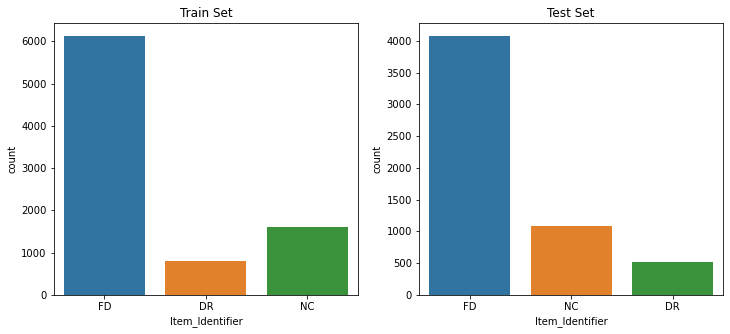

In [67]:
#Plotting the number of items that belong to these three categories

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Identifier'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Identifier'])

plt.show()

#### Item_Fat_Content

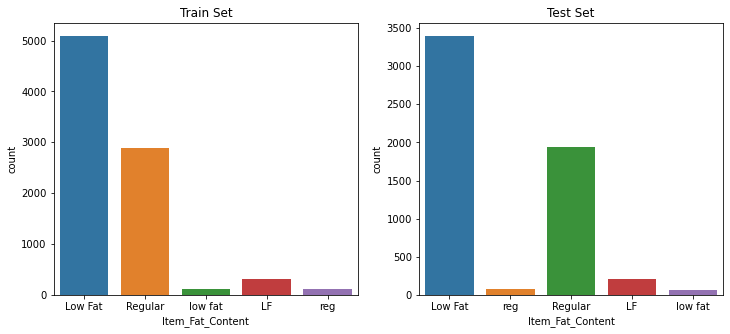

In [68]:
#Plotting the number of items in the Item_Fat_Content column

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Fat_Content'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Fat_Content'])

plt.show()

It looks like 'LF' and 'low fat' are the same as the category 'Low Fat'. The same applies to 'reg' and 'Regular'.

In [69]:
#Substituting 'Low Fat' inplace of 'low fat' and 'LF'

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('low fat', 'Low Fat', x))
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('LF', 'Low Fat', x))

test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('low fat', 'Low Fat', x))
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('LF', 'Low Fat', x))


#Substituting 'Regular' inplace of 'reg'

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('reg', 'Regular', x))
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('reg', 'Regular', x))

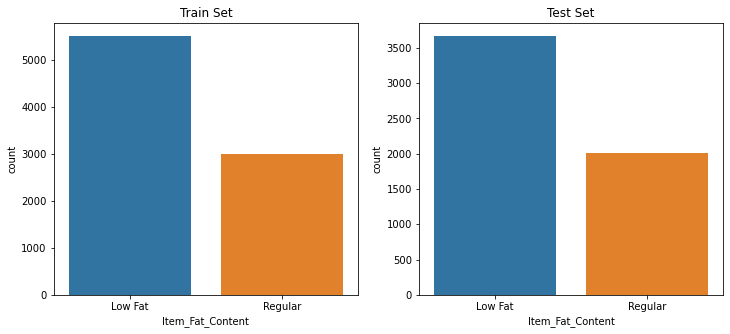

In [70]:
#Checking the Item_Fat_Content column again

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Fat_Content'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Fat_Content'])

plt.show()

#### Item_Type

In [71]:
print(train_df['Item_Type'].unique(), "\n")
print("Number of item types: ", len(train_df['Item_Type'].unique()))

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood'] 

Number of item types:  16


#### Outlet_Identifier

In [72]:
print(train_df['Outlet_Identifier'].unique(), "\n")
print("Number of outlets: ", len(train_df['Outlet_Identifier'].unique()))

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019'] 

Number of outlets:  10


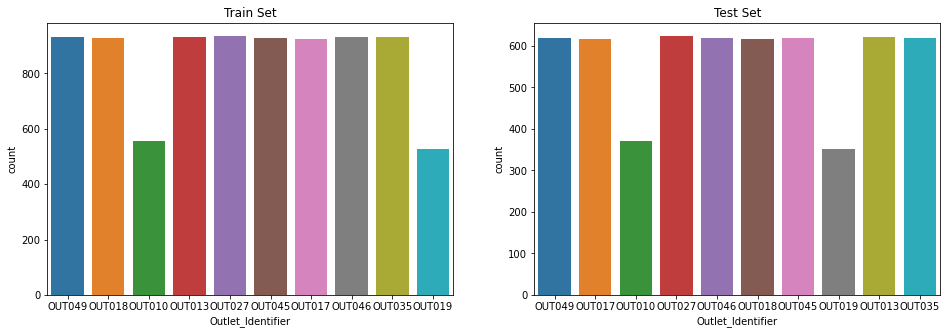

In [73]:
#Checking the Outlet_Identifier column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Identifier'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Identifier'])

plt.show()

#### Outlet_Establishment_Year

In [74]:
print(train_df['Outlet_Establishment_Year'].unique(), "\n")
print("Number of outlets: ", len(train_df['Outlet_Establishment_Year'].unique()))

[1999 2009 1998 1987 1985 2002 2007 1997 2004] 

Number of outlets:  9


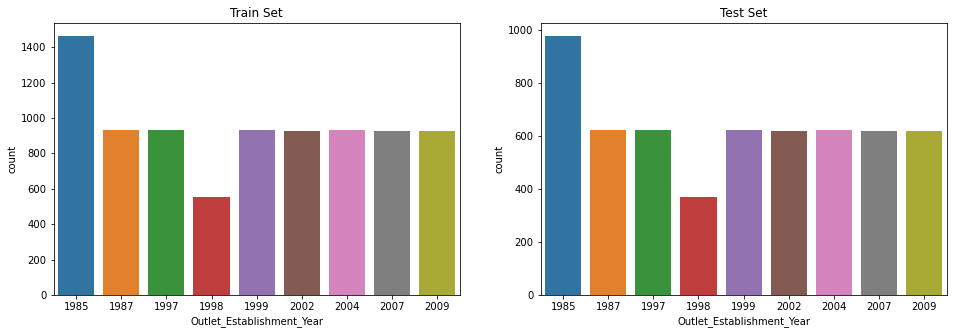

In [75]:
#Checking the Outlet_Establishment_Year column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Establishment_Year'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Establishment_Year'])

plt.show()

Since the year of establishing an outlet cannot be used directly in a model, I'll convert these years into age of the outlet.

In [76]:
#I'll consider the age of the outlet in the year 2010
train_df['Outlet_Establishment_Year'] = 2010 - train_df['Outlet_Establishment_Year']
test_df['Outlet_Establishment_Year'] = 2010 - test_df['Outlet_Establishment_Year']

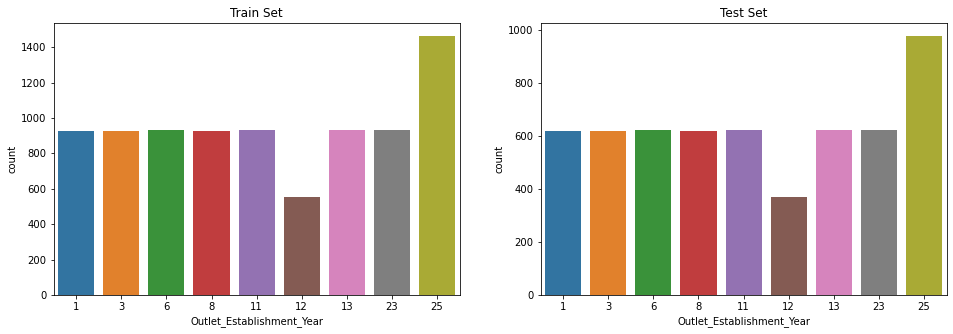

In [77]:
#Checking the Outlet_Establishment_Year column again

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Establishment_Year'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Establishment_Year'])

plt.show()

As we can see from these graphs, most outlets were established in 1985 and are 25 years old in the year 2010.

#### Outlet_Size

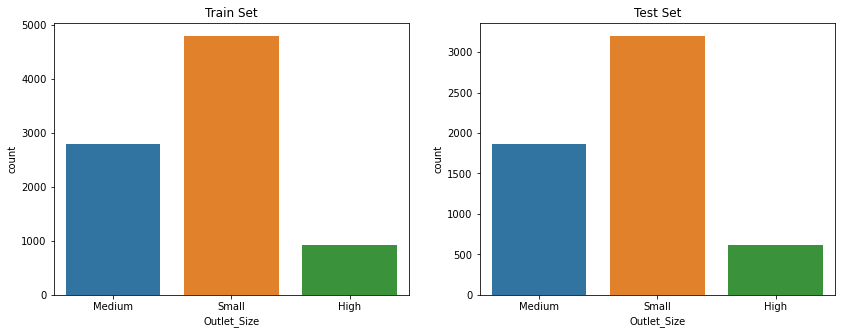

In [78]:
#Checking the Outlet_Size column

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Size'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Size'])

plt.show()

#### Outlet_Location_Type

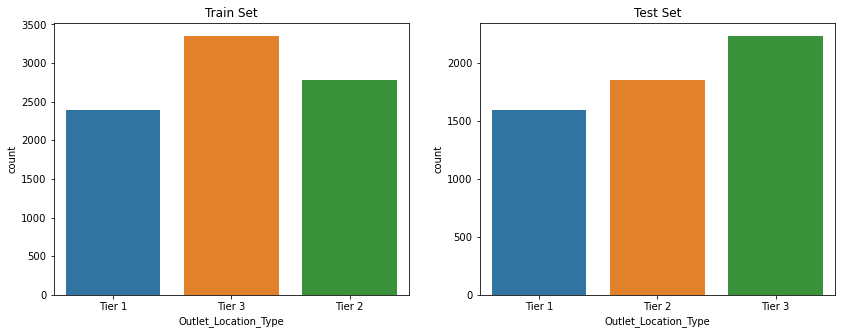

In [79]:
#Checking the Outlet_Location_Type column

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Location_Type'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Location_Type'])

plt.show()

#### Outlet_Type

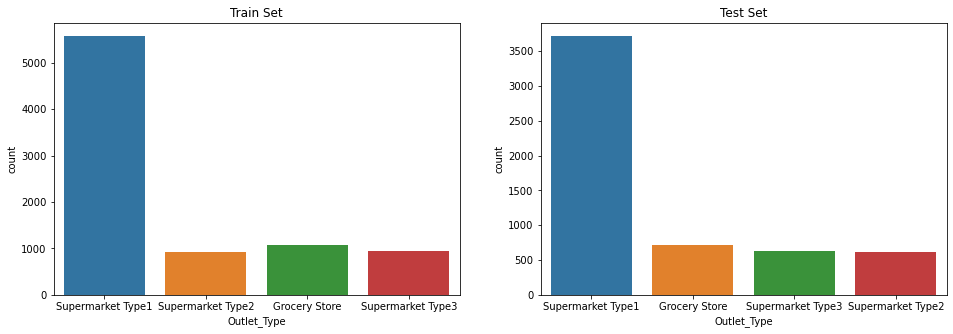

In [80]:
#Checking the Outlet_Type column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Type'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Type'])

plt.show()

#### Continous Variables

In [81]:
#Checking the spread of continous variables
train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.066132,140.992782,12.168133
std,4.645893,0.051598,62.275067,8.371760
min,4.555000,0.000000,31.290000,1.000000
25%,8.785000,0.026989,93.826500,6.000000
50%,12.600000,0.053931,143.012800,11.000000
75%,16.850000,0.094585,185.643700,23.000000
max,21.350000,0.328391,266.888400,25.000000


There don't appear to be any outliers.

Next, let's visualize the scatter plots for these variables.

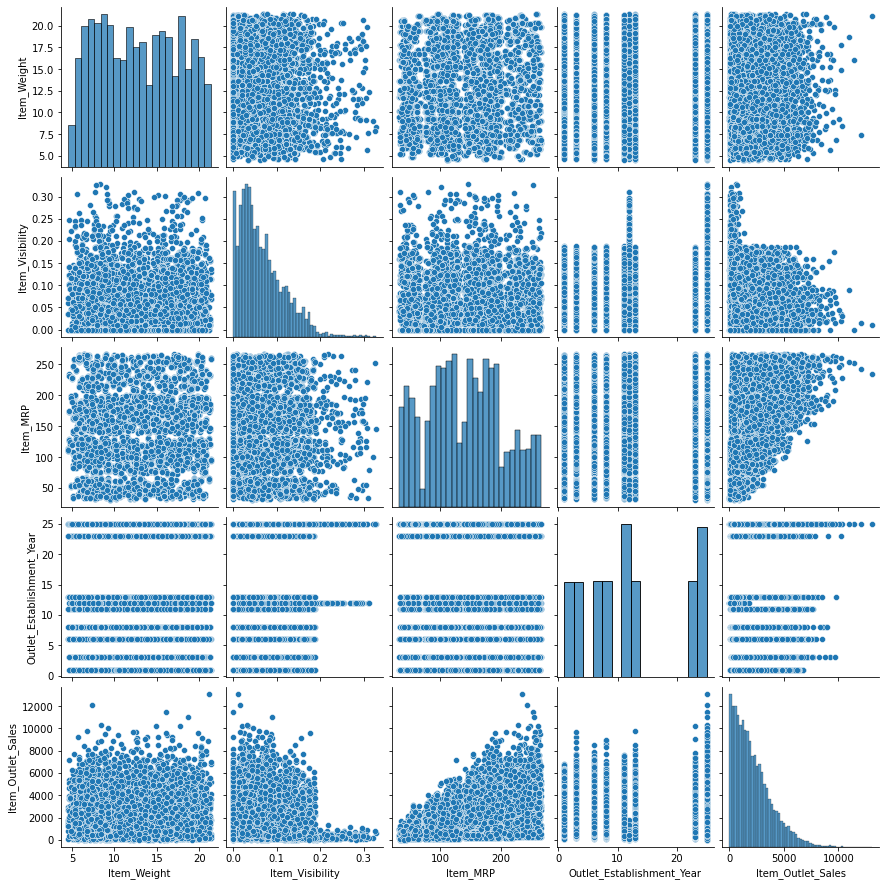

In [82]:
sns.pairplot(train_df)
plt.show()

A few interesting things to note from these graphs.
- For Item_Visibility > 0.2, there is a steep drop off in sales. This might suggest that customers don't like to buy items that they see everywhere in the shop.
- Items with higher MRP lead to higher sales amounts, which is to be expected.
- From the Item_Outlet_Sales histogram, we can see that most items do not generate high sales volume. Very few items generate high sales volume.

In [83]:
#Let's check the pairwise correlations of these variables
train_df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.009661,0.026172,0.012823,0.013261
Item_Visibility,-0.009661,1.000000,-0.001315,0.074834,-0.128625
Item_MRP,0.026172,-0.001315,1.000000,-0.005020,0.567574
Outlet_Establishment_Year,0.012823,0.074834,-0.005020,1.000000,0.049135
Item_Outlet_Sales,0.013261,-0.128625,0.567574,0.049135,1.000000


As we saw in the scatter plots, Item_MRP rises with Item_Outlet_Sales and has the highest correlation with the target variable.

In [84]:
#Checking the spread of these variables again
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.066132,140.992782,12.168133,2181.288914
std,4.645893,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1.000000,33.290000
25%,8.785000,0.026989,93.826500,6.000000,834.247400
50%,12.600000,0.053931,143.012800,11.000000,1794.331000
75%,16.850000,0.094585,185.643700,23.000000,3101.296400
max,21.350000,0.328391,266.888400,25.000000,13086.964800


The minimum value in the Item_Visibility column is zero. If the item is on display in the outlet, the visibility percentage should not be zero. I'll check if Item_Outlet_Sales = 0 when Item_Visibility = 0, as this would indicate that the item is not on the shelves of the outlet.

In [85]:
#Checking if an item is not on the shelves of an outlet when the visibility is zero
train_df[(train_df['Item_Visibility']==0) & (train_df['Item_Outlet_Sales']==0)]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


It looks like even items with zero visibility are present on the shelf in outlets, as they have a corresponding sales figure.

In [86]:
#Checking if the item visibility is zero only in a particular outlet

print("Number of outlets: ", len(train_df['Outlet_Identifier'].unique()))
print("Number of outlets with item visibility zero for an item: ", 
      len(train_df['Outlet_Identifier'][train_df['Item_Visibility']==0].unique()))

Number of outlets:  10
Number of outlets with item visibility zero for an item:  10


In [87]:
#Checking if the item visibility is zero only for a particular item

print("Number of items: ", len(train_df['Item_Type'].unique()))
print("Number of items with item visibility zero: ", 
      len(train_df['Item_Type'][train_df['Item_Visibility']==0].unique()))

Number of items:  16
Number of items with item visibility zero:  16


It looks like all items have zero visibility in one outlet or another. Similarly, all outlets have at least one item with zero visibility. This is unlikely to be a data entry error and more likely to be a result of rounding values lower than a threshold value to zero.

In [88]:
#Checking for the lowest non-zero values in the Item_Visibility column
print("Number of rows where 0 < Item_Visibility < 0.01: ", train_df[(train_df['Item_Visibility'] < 0.01) & (train_df['Item_Visibility'] > 0)].shape[0])
print("Number of rows where 0 < Item_Visibility < 0.001: ", train_df[(train_df['Item_Visibility'] < 0.001) & (train_df['Item_Visibility'] > 0)].shape[0])

Number of rows where 0 < Item_Visibility < 0.01:  206
Number of rows where 0 < Item_Visibility < 0.001:  0


It looks like values lower than 0.001 have been rounded to zero in this column. I'll add 0.001 to all values of this column, as Item_Visibility is a percentage and 0.001 = 0.1%

In [89]:
#Checking if the test set also has zero values in the Item_Visibility column
test_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,5681.000000,5681.000000,5681.000000,5681.000000
mean,12.672996,0.065684,141.023273,12.171097
std,4.658256,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1.000000
25%,8.615000,0.027047,94.412000,6.000000
50%,12.350000,0.054154,141.415400,11.000000
75%,16.700000,0.093463,186.026600,23.000000
max,21.350000,0.323637,266.588400,25.000000


Adding 0.001 to all Item_Visibility values.

In [90]:
train_df['Item_Visibility'] = train_df['Item_Visibility'] + 0.001
test_df['Item_Visibility'] = test_df['Item_Visibility'] + 0.001

#### Item_Outlet_Sales

Let's check the distribution of the target variable.

In [161]:
sns.distplot(train_df['Item_Outlet_Sales'], hist=False)
plt.show()

KeyError: 'Item_Outlet_Sales'

## Data Preparation

In [92]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import yeojohnson

In [93]:
#Checking the plots for different transformations

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.title("Box-Cox")
pt = PowerTransformer(method='box-cox')
#Using pd.DataFrame as the input needs to be of the shape (n, 1) and not (n, )
sns.distplot(pt.fit_transform(pd.DataFrame(train_df['Item_Outlet_Sales'])), hist=False)

plt.subplot(2, 2, 2)
plt.title("Log")
sns.distplot(np.log1p(train_df['Item_Outlet_Sales']), hist=False)

plt.subplot(2, 2, 3)
plt.title("Square-root")
sns.distplot(train_df['Item_Outlet_Sales']**(1/2), hist=False)

plt.subplot(2, 2, 4)
plt.title("Yeo-johnson")
yf_target, lam = yeojohnson(train_df['Item_Outlet_Sales'])
sns.distplot(yf_target, hist=False)


plt.show()

In [94]:
#Transforming the target variable
train_df['Item_Outlet_Sales'] = pt.fit_transform(pd.DataFrame(train_df['Item_Outlet_Sales']))

In [96]:
train_df.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.300,Low Fat,0.017047,Dairy,249.8092,OUT049,11,Medium,Tier 1,Supermarket Type1,0.984978
1,DR,5.920,Regular,0.020278,Soft Drinks,48.2692,OUT018,1,Medium,Tier 3,Supermarket Type2,-1.217837
2,FD,17.500,Low Fat,0.017760,Meat,141.6180,OUT049,11,Medium,Tier 1,Supermarket Type1,0.220282
3,FD,19.200,Regular,0.001000,Fruits and Vegetables,182.0950,OUT010,12,Small,Tier 3,Grocery Store,-0.834969
4,NC,8.930,Low Fat,0.001000,Household,53.8614,OUT013,23,High,Tier 3,Supermarket Type1,-0.566490
5,FD,10.395,Regular,0.001000,Baking Goods,51.4008,OUT018,1,Medium,Tier 3,Supermarket Type2,-1.052591
6,FD,13.650,Regular,0.013741,Snack Foods,57.6588,OUT013,23,High,Tier 3,Supermarket Type1,-1.388458
7,FD,19.000,Low Fat,0.128470,Snack Foods,107.7622,OUT027,25,Medium,Tier 3,Supermarket Type3,1.094830
8,FD,16.200,Regular,0.017687,Frozen Foods,96.9726,OUT045,8,Small,Tier 2,Supermarket Type1,-0.492352
9,FD,19.200,Regular,0.095450,Frozen Foods,187.8214,OUT017,3,Small,Tier 2,Supermarket Type1,1.338156


#### Engineering a new feature

We've seen that Item_Outlet_Sales increases with Item_MRP, but there's a drop off in Item_Outlet_Sales if Item_Visbility > 0.2. Let's divide Item_MRP by Item_Visbility and add this as a new variable.

In [97]:
#Diving the ratio by 100, as this ratio takes very high values
train_df['MRP_by_Visibility'] = train_df['Item_MRP']/(train_df['Item_Visibility']*100)
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,MRP_by_Visibility
0,FD,9.30,Low Fat,0.017047,Dairy,249.8092,OUT049,11,Medium,Tier 1,Supermarket Type1,0.984978,146.538857
1,DR,5.92,Regular,0.020278,Soft Drinks,48.2692,OUT018,1,Medium,Tier 3,Supermarket Type2,-1.217837,23.803475
2,FD,17.50,Low Fat,0.017760,Meat,141.6180,OUT049,11,Medium,Tier 1,Supermarket Type1,0.220282,79.739528
3,FD,19.20,Regular,0.001000,Fruits and Vegetables,182.0950,OUT010,12,Small,Tier 3,Grocery Store,-0.834969,1820.950000
4,NC,8.93,Low Fat,0.001000,Household,53.8614,OUT013,23,High,Tier 3,Supermarket Type1,-0.566490,538.614000


Let's check the scatter plot of this variable against the target variable.`

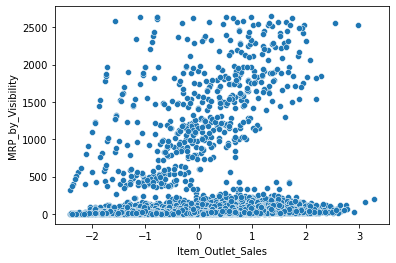

In [98]:
sns.scatterplot(train_df['Item_Outlet_Sales'], train_df['MRP_by_Visibility'])
plt.show()

The new variable increases with Item_Outlet_Sales, but only above a certain value (~250) of MRP_by_visibility.

In [99]:
#Checking the pairwise correlations again
train_df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,MRP_by_Visibility
Item_Weight,1.000000,-0.009661,0.026172,0.012823,0.009938,-0.019013
Item_Visibility,-0.009661,1.000000,-0.001315,0.074834,-0.172127,-0.349289
Item_MRP,0.026172,-0.001315,1.000000,-0.005020,0.552759,0.137951
Outlet_Establishment_Year,0.012823,0.074834,-0.005020,1.000000,-0.028315,-0.008756
Item_Outlet_Sales,0.009938,-0.172127,0.552759,-0.028315,1.000000,0.097473
MRP_by_Visibility,-0.019013,-0.349289,0.137951,-0.008756,0.097473,1.000000


The correlation of the new variable (with the target variable) is not as high as Item_MRP, but it has the second-highest correlation with the target variable.

In [100]:
#Adding this variable to the test set
test_df['MRP_by_Visibility'] = test_df['Item_MRP']/(train_df['Item_Visibility']*100)
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,MRP_by_Visibility
0,FD,20.750,Low Fat,0.008565,Snack Foods,107.8622,OUT049,11,Medium,Tier 1,Supermarket Type1,63.272303
1,FD,8.300,Regular,0.039428,Dairy,87.3198,OUT017,3,Small,Tier 2,Supermarket Type1,43.060889
2,NC,14.600,Low Fat,0.100575,Others,241.7538,OUT010,12,Small,Tier 3,Grocery Store,136.122060
3,FD,7.315,Low Fat,0.016388,Snack Foods,155.0340,OUT017,3,Small,Tier 2,Supermarket Type1,1550.340000
4,FD,13.600,Regular,0.119599,Dairy,234.2300,OUT027,25,Medium,Tier 3,Supermarket Type3,2342.300000


### Encoding Categorical Data

In [101]:
#Creating an object of the OneHotEncoder class
enc = OneHotEncoder()

In [102]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels = enc.fit_transform(train_df[['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                           'Outlet_Location_Type', 'Outlet_Type']])


#Using the original column names to make the encoded columns easier to read

col_names = enc.get_feature_names(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                   'Outlet_Location_Type', 'Outlet_Type'])

In [103]:
#Converting the encoded columns into a dataframe

encoded_columns = pd.DataFrame(onehotlabels.toarray().astype(int), columns = col_names)
encoded_columns.columns

Index(['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Identifier_NC',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [104]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns = encoded_columns.drop(['Item_Identifier_NC', 'Item_Fat_Content_Low Fat', 'Outlet_Size_High', 
                                       'Outlet_Location_Type_Tier 1', 'Outlet_Type_Supermarket Type2'], axis =1)

In [105]:
print("Shape of encoded columns:\n", encoded_columns.shape)
print("\n")
print("Shape of original train set: \n", train_df.shape)

Shape of encoded columns:
 (8523, 10)


Shape of original train set: 
 (8523, 13)


Merging these encoded columns with the original dataframe

In [106]:
train_df = pd.concat([train_df, encoded_columns], axis = 1)

In [107]:
#Dropping the columns that have been encoded
train_df = train_df.drop(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 
                          'Outlet_Type'], axis = 1)

In [108]:
train_df.shape

(8523, 18)

#### Encoding the Outlet_Identifier column

In [109]:
#Checking the number of outlet identifiers
len(train_df['Outlet_Identifier'].unique())

10

I'll use feature hashing to encode this column, as there will be too many variables if I use one hot encoding.

To learn how hashing works:
https://towardsdatascience.com/know-about-categorical-encoding-even-new-ones-c266227b9cbd

In [110]:
#Instantiating the FeatureHasher class for the Outlet_Identifier column with number of output featuers = 4
fh_OI = FeatureHasher(n_features = 4, input_type='string')

#Transforming the column Outlet_Identifier
hashed_features_OI = fh_OI.fit_transform(train_df['Outlet_Identifier'])

In [111]:
#Converting the hash columns to an array
hashed_features_OI = hashed_features_OI.toarray()

#Concatenating the hash columns with the original dataframe
train_df = pd.concat([train_df, pd.DataFrame(hashed_features_OI)], axis = 1)

#Dropping the original column
train_df = train_df.drop(['Outlet_Identifier'], axis = 1)

In [112]:
train_df.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,MRP_by_Visibility,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,...,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,0,1,2,3
0,9.30,0.017047,Dairy,249.8092,11,0.984978,146.538857,0,1,0,...,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
1,5.92,0.020278,Soft Drinks,48.2692,1,-1.217837,23.803475,1,0,1,...,0,0,1,0,0,0,0.0,-4.0,0.0,0.0
2,17.50,0.017760,Meat,141.6180,11,0.220282,79.739528,0,1,0,...,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
3,19.20,0.001000,Fruits and Vegetables,182.0950,12,-0.834969,1820.950000,0,1,1,...,1,0,1,1,0,0,0.0,-4.0,0.0,0.0
4,8.93,0.001000,Household,53.8614,23,-0.566490,538.614000,0,0,0,...,0,0,1,0,1,0,1.0,-3.0,0.0,0.0


I'll change the hashed column names to something more meaningful.

In [113]:
#Renaming the columns using a dictioanry
train_df.rename(columns = {0: 'Out_ID_H0', 1: 'Out_ID_H1', 2: 'Out_ID_H2', 3: 'Out_ID_H3'}, inplace=True)

#### Encoding the Item_Type column

In [114]:
#Checking the number of item types
len(train_df['Item_Type'].unique())

16

Using feature hasher again, as there are too many categories for one hot encoding.

In [115]:
#Instantiating the FeatureHasher class for the Outlet_Identifier column with number of output featuers = 4
fh_IT = FeatureHasher(n_features = 4, input_type='string')

#Transforming the Item_Type column
hashed_features_IT = fh_IT.fit_transform(train_df['Item_Type'])

In [116]:
#Converting the hash columns to an array
hashed_features_IT = hashed_features_IT.toarray()

#Concatenating the hash columns with the original dataframe
train_df = pd.concat([train_df, pd.DataFrame(hashed_features_IT)], axis = 1)

#Dropping the original column
train_df = train_df.drop(['Item_Type'], axis = 1)

In [117]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,MRP_by_Visibility,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,...,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,0,1,2,3
0,9.30,0.017047,249.8092,11,0.984978,146.538857,0,1,0,1,...,1,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0
1,5.92,0.020278,48.2692,1,-1.217837,23.803475,1,0,1,1,...,0,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0
2,17.50,0.017760,141.6180,11,0.220282,79.739528,0,1,0,1,...,1,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0
3,19.20,0.001000,182.0950,12,-0.834969,1820.950000,0,1,1,0,...,0,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0
4,8.93,0.001000,53.8614,23,-0.566490,538.614000,0,0,0,0,...,1,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0


In [118]:
#Renaming the columns using a dictioanry
train_df.rename(columns = {0: 'IT_H0', 1: 'IT_H1', 2: 'IT_H2', 3: 'IT_H3'}, inplace=True)

#### Moving the target variable column to the end

In [119]:
#Getting a list of column names to rearrange them
cols = train_df.columns.tolist()
cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'MRP_by_Visibility',
 'Item_Identifier_DR',
 'Item_Identifier_FD',
 'Item_Fat_Content_Regular',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type3',
 'Out_ID_H0',
 'Out_ID_H1',
 'Out_ID_H2',
 'Out_ID_H3',
 'IT_H0',
 'IT_H1',
 'IT_H2',
 'IT_H3']

In [120]:
#Putting target variable at the end
cols = cols[:4] + cols[5:] + [cols[4]]
train_df = train_df[cols]
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,MRP_by_Visibility,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,...,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3,Item_Outlet_Sales
0,9.30,0.017047,249.8092,11,146.538857,0,1,0,1,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.984978
1,5.92,0.020278,48.2692,1,23.803475,1,0,1,1,0,...,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0,-1.217837
2,17.50,0.017760,141.6180,11,79.739528,0,1,0,1,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.220282
3,19.20,0.001000,182.0950,12,1820.950000,0,1,1,0,1,...,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0,-0.834969
4,8.93,0.001000,53.8614,23,538.614000,0,0,0,0,0,...,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0,-0.566490


### Encoding the test data

In [121]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels_test = enc.transform(test_df[['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                           'Outlet_Location_Type', 'Outlet_Type']])

In [122]:
#Converting the encoded columns into a dataframe and using the same col_names variable that was created for the train set

encoded_columns_test = pd.DataFrame(onehotlabels_test.toarray().astype(int), columns = col_names)
encoded_columns_test.columns

Index(['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Identifier_NC',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [123]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns_test = encoded_columns_test.drop(['Item_Identifier_NC', 'Item_Fat_Content_Low Fat', 'Outlet_Size_High', 
                                       'Outlet_Location_Type_Tier 1', 'Outlet_Type_Supermarket Type2'], axis =1)

In [124]:
#Merging the encoded columns with the original dataframe

test_df = pd.concat([test_df, encoded_columns_test], axis = 1)

In [125]:
#Dropping the columns that have been encoded
test_df = test_df.drop(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 
                          'Outlet_Type'], axis = 1)

Encoding the Outlet_Identifier column

In [126]:
#Transforming the Outlet_Identifier column
hashed_features_OI_test = fh_OI.transform(test_df['Outlet_Identifier'])

In [127]:
#Converting the hash columns to an array
hashed_features_OI_test = hashed_features_OI_test.toarray()

#Concatenating the hash columns with the original dataframe
test_df = pd.concat([test_df, pd.DataFrame(hashed_features_OI_test)], axis = 1)

#Dropping the original column
test_df = test_df.drop(['Outlet_Identifier'], axis = 1)

In [128]:
test_df.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,MRP_by_Visibility,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,0,1,2,3
0,20.750,0.008565,Snack Foods,107.8622,11,63.272303,0,1,0,1,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
1,8.300,0.039428,Dairy,87.3198,3,43.060889,0,1,1,0,1,1,0,0,1,0,1.0,-3.0,0.0,0.0
2,14.600,0.100575,Others,241.7538,12,136.122060,0,0,0,0,1,0,1,1,0,0,0.0,-4.0,0.0,0.0
3,7.315,0.016388,Snack Foods,155.0340,3,1550.340000,0,1,0,0,1,1,0,0,1,0,1.0,-3.0,0.0,0.0
4,13.600,0.119599,Dairy,234.2300,25,2342.300000,0,1,1,1,0,0,1,0,0,1,1.0,-2.0,0.0,1.0


In [129]:
#Renaming the columns using a dictioanry
test_df.rename(columns = {0: 'Out_ID_H0', 1: 'Out_ID_H1', 2: 'Out_ID_H2', 3: 'Out_ID_H3'}, inplace=True)

Encoding the Item_Type column

In [130]:
#Transforming the Item_Type column
hashed_features_IT_test = fh_IT.transform(test_df['Item_Type'])

In [131]:
#Converting the hash columns to an array
hashed_features_IT_test = hashed_features_IT_test.toarray()

#Concatenating the hash columns with the original dataframe
test_df = pd.concat([test_df, pd.DataFrame(hashed_features_IT_test)], axis = 1)

#Dropping the original column
test_df = test_df.drop(['Item_Type'], axis = 1)

In [132]:
#Renaming the columns using a dictioanry
test_df.rename(columns = {0: 'IT_H0', 1: 'IT_H1', 2: 'IT_H2', 3: 'IT_H3'}, inplace=True)

In [133]:
test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,MRP_by_Visibility,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,...,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3
0,20.750,0.008565,107.8622,11,63.272303,0,1,0,1,0,...,1,0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,1.0
1,8.300,0.039428,87.3198,3,43.060889,0,1,1,0,1,...,1,0,1.0,-3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,14.600,0.100575,241.7538,12,136.122060,0,0,0,0,1,...,0,0,0.0,-4.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,7.315,0.016388,155.0340,3,1550.340000,0,1,0,0,1,...,1,0,1.0,-3.0,0.0,0.0,-1.0,-1.0,0.0,1.0
4,13.600,0.119599,234.2300,25,2342.300000,0,1,1,1,0,...,0,1,1.0,-2.0,0.0,1.0,0.0,0.0,3.0,0.0


### Scaling the continuous variables

In [134]:
train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.067132,140.992782,12.168133
std,4.645893,0.051598,62.275067,8.371760
min,4.555000,0.001000,31.290000,1.000000
25%,8.785000,0.027989,93.826500,6.000000
50%,12.600000,0.054931,143.012800,11.000000
75%,16.850000,0.095585,185.643700,23.000000
max,21.350000,0.329391,266.888400,25.000000


In [135]:
#Creating a standard scaler object
scaler = StandardScaler()

In [136]:
#Making a list of columns that are to be scaled
var_for_scaling = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [137]:
#Scaling the columns
train_df[var_for_scaling] = scaler.fit_transform(train_df[var_for_scaling])

In [138]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,MRP_by_Visibility,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,...,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3,Item_Outlet_Sales
0,-0.769246,-0.970732,1.747454,-0.139541,146.538857,0,1,0,1,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.984978
1,-1.496813,-0.908111,-1.489023,-1.334103,23.803475,1,0,1,1,0,...,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0,-1.217837
2,0.995858,-0.956917,0.010040,-0.139541,79.739528,0,1,0,1,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.220282
3,1.361794,-1.281758,0.660050,-0.020085,1820.950000,0,1,1,0,1,...,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0,-0.834969
4,-0.848890,-1.281758,-1.399220,1.293934,538.614000,0,0,0,0,0,...,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0,-0.566490


In [139]:
#Scaling the columns in the test set
test_df[var_for_scaling] = scaler.transform(test_df[var_for_scaling])

In [140]:
test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,MRP_by_Visibility,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,...,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3
0,1.695442,-1.135138,-0.532035,-0.139541,63.272303,0,1,0,1,0,...,1,0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,1.0
1,-0.984502,-0.536960,-0.861920,-1.095190,43.060889,0,1,1,0,1,...,1,0,1.0,-3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,0.371614,0.648183,1.618094,-0.020085,136.122060,0,0,0,0,1,...,0,0,0.0,-4.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,-1.196530,-0.983503,0.225484,-1.095190,1550.340000,0,1,0,0,1,...,1,0,1.0,-3.0,0.0,0.0,-1.0,-1.0,0.0,1.0
4,0.156357,1.016910,1.497272,1.532846,2342.300000,0,1,1,1,0,...,0,1,1.0,-2.0,0.0,1.0,0.0,0.0,3.0,0.0


### Splitting the data set

In [141]:
#Splitting the data 70-30

train_df, val_df = train_test_split(train_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [142]:
#Splitting into X_train and y_train (and X_val and y_val)

y_train = train_df.pop('Item_Outlet_Sales')
X_train = train_df

y_val = val_df.pop('Item_Outlet_Sales')
X_val = val_df

In [143]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5966, 23)
(5966,)
(2557, 23)
(2557,)


## Model Building

### 1. Linear Regression Model

In [144]:
#Creating a linear regression object with an intercept
lm = LinearRegression(fit_intercept=True)

#Fitting the model on the train set
lm.fit(X_train, y_train)

LinearRegression()

In [145]:
#Making predictions on the train and validation set
y_train_predictions_lr = lm.predict(X_train)
y_val_predictions_lr = lm.predict(X_val)

#Calculating the RMSE for the train and val sets
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predictions_lr))
lr_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions_lr))

print('Train dataset RMSE: ', round(lr_train_rmse, 4))
print('Validation dataset RMSE: ', round(lr_val_rmse, 4))

Train dataset RMSE:  0.5633
Validation dataset RMSE:  0.5661


In [146]:
#Calculating the R-squared value for the train and val sets
lr_train_score = r2_score(y_train, y_train_predictions_lr)
lr_val_score = r2_score(y_val, y_val_predictions_lr)

print("Train set R-squared value: {:.4f}" .format(lr_train_score))
print("Validation set R-squared value: {:.4f}" .format(lr_val_score))

Train set R-squared value: 0.6865
Validation set R-squared value: 0.6703


### 2. Decision Tree Model

In [147]:
#Creating the parameter grid
param_grid = {
    'max_depth': [4, 8, 12, 16],
    'min_samples_leaf': [10, 25, 50, 75, 100, 125],
    'max_leaf_nodes': [10, 25, 50, 75, 100, 125, 150],
    'max_features' : ['auto', 'log2']
}

n_folds = 5

# Instantiate the grid search model
dtree_grid = DecisionTreeRegressor(random_state=100, criterion = 'mse')
grid_search_dtree = GridSearchCV(estimator = dtree_grid, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, n_jobs=-1)

# Fit the grid search to the data
grid_search_dtree.fit(X_train, y_train)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:    7.9s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 12, 16],
                         'max_features': ['auto', 'log2'],
                         'max_leaf_nodes': [10, 25, 50, 75, 100, 125, 150],
                         'min_samples_leaf': [10, 25, 50, 75, 100, 125]},
             verbose=1)

In [148]:
# printing the optimal accuracy score and hyperparameters
print("best score", grid_search_dtree.best_score_)
print(grid_search_dtree.best_estimator_)

best score 0.6887787787129285
DecisionTreeRegressor(max_depth=8, max_features='auto', max_leaf_nodes=25,
                      min_samples_leaf=10, random_state=100)


In [149]:
# model with optimal hyperparameters
dtree = DecisionTreeRegressor(max_depth=8,
                              max_features = 'auto',
                              max_leaf_nodes=50,
                              min_samples_leaf=125,
                              random_state = 100,
                              criterion = 'mse'
                             )

dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, max_features='auto', max_leaf_nodes=50,
                      min_samples_leaf=125, random_state=100)

In [150]:
#Making predictions on the train and validation set
y_train_predictions_dtree = dtree.predict(X_train)
y_val_predictions_dtree = dtree.predict(X_val)

#Calculating the RMSE for the train and val sets
dtree_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predictions_lr))
dtree_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions_lr))

print('Train dataset RMSE: ', round(dtree_train_rmse, 4))
print('Validation dataset RMSE: ', round(dtree_val_rmse, 4))

Train dataset RMSE:  0.5633
Validation dataset RMSE:  0.5661


### 3. Random Forest

In [151]:
#Creating the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 175, 200],
    'max_depth': [4, 6, 8, 12, 14],
    'min_samples_leaf': [10, 25, 50, 75, 100],
    'max_leaf_nodes': [10, 25, 50, 75, 100],
    'max_features' : ['auto', 'log2']
}

n_folds = 5

# Instantiate the grid search model
rf_grid = RandomForestRegressor(random_state=100, criterion = 'mse')
grid_search_rf = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1250 candidates, totalling 6250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 6250 out of 6250 | elapsed: 10.9min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 12, 14],
                         'max_features': ['auto', 'log2'],
                         'max_leaf_nodes': [10, 25, 50, 75, 100],
                         'min_samples_leaf': [10, 25, 50, 75, 100],
                         'n_estimators': [50, 100, 150, 175, 200]},
             verbose=1)

In [152]:
# printing the optimal accuracy score and hyperparameters
print("best score", grid_search_rf.best_score_)
print(grid_search_rf.best_estimator_)

best score 0.6979107496402612
RandomForestRegressor(max_depth=6, max_leaf_nodes=25, min_samples_leaf=25,
                      n_estimators=200, random_state=100)


In [153]:
# model with optimal hyperparameters
rf = RandomForestRegressor(max_depth=6,
                           max_leaf_nodes=50,
                           min_samples_leaf=25,
                           n_estimators=200,
                           random_state=100
                           )

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_leaf_nodes=50, min_samples_leaf=25,
                      n_estimators=200, random_state=100)

In [154]:
#Making predictions on the train and validation set
y_train_predictions_rf = rf.predict(X_train)
y_val_predictions_rf = rf.predict(X_val)

#Calculating the RMSE for the train and val sets
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predictions_rf))
rf_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions_rf))

print('Train dataset RMSE: ', round(rf_train_rmse, 4))
print('Validation dataset RMSE: ', round(rf_val_rmse, 4))

Train dataset RMSE:  0.5376
Validation dataset RMSE:  0.5512


In [155]:
train_df.shape

(5966, 23)

In [156]:
test_df.shape

(5681, 23)

### 4. CatBoost

In [157]:
#Defining the parameter grid

param_grid = {'n_estimators': [25, 50, 75, 100],
              'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.25],
              'max_depth': [4, 6, 8, 10],
              'num_leaves': [16, 32, 64, 96, 128],
              'l2_leaf_reg': [0.5, 1, 2, 3, 4, 5]
              }


#Specify the number of folds (note that StratifiedKFold can't be used with a continuous target variable)
n_folds = 5


# Instantiate the LGBM classifier
cb_grid = CatBoostRegressor(random_state = 100,
                              loss_function = 'RMSE'
                            )


grid_search_cb = GridSearchCV(estimator = cb_grid, param_grid = param_grid, cv = n_folds, verbose=1, n_jobs=-1)


# Fit the grid search to the data
grid_search_cb.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1427 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 3324 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5815 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7248 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9039 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 11033 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 12000 out of 12000 | elapsed:  4.3min finished


0:	learn: 0.9745267	total: 135ms	remaining: 13.4s
1:	learn: 0.9454566	total: 137ms	remaining: 6.72s
2:	learn: 0.9172968	total: 139ms	remaining: 4.48s
3:	learn: 0.8910687	total: 140ms	remaining: 3.37s
4:	learn: 0.8679582	total: 142ms	remaining: 2.7s
5:	learn: 0.8448284	total: 143ms	remaining: 2.25s
6:	learn: 0.8240724	total: 145ms	remaining: 1.93s
7:	learn: 0.8057732	total: 146ms	remaining: 1.68s
8:	learn: 0.7869414	total: 148ms	remaining: 1.49s
9:	learn: 0.7714820	total: 149ms	remaining: 1.34s
10:	learn: 0.7548692	total: 151ms	remaining: 1.22s
11:	learn: 0.7395953	total: 153ms	remaining: 1.12s
12:	learn: 0.7250460	total: 155ms	remaining: 1.03s
13:	learn: 0.7116708	total: 156ms	remaining: 958ms
14:	learn: 0.6988498	total: 158ms	remaining: 895ms
15:	learn: 0.6872890	total: 160ms	remaining: 841ms
16:	learn: 0.6770497	total: 161ms	remaining: 788ms
17:	learn: 0.6674835	total: 163ms	remaining: 740ms
18:	learn: 0.6581420	total: 164ms	remaining: 699ms
19:	learn: 0.6497609	total: 165ms	remainin

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001AEB2FF8040>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [0.5, 1, 2, 3, 4, 5],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.25],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [25, 50, 75, 100],
                         'num_leaves': [16, 32, 64, 96, 128]},
             verbose=1)

In [158]:
#Viewing the best parameters from the grid search
print(grid_search_cb.best_params_)
print(grid_search_cb.best_score_)

{'l2_leaf_reg': 5, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 16}
0.7014909151780436


In [159]:
#Fitting a CatBoost model
cb_model = CatBoostRegressor(l2_leaf_reg = 5, learning_rate = 0.1, max_depth = 4, n_estimators = 50, 
                             num_leaves = 16)
cb_model.fit(X_train, y_train)

0:	learn: 0.9483990	total: 3.94ms	remaining: 193ms
1:	learn: 0.8959529	total: 5.32ms	remaining: 128ms
2:	learn: 0.8464279	total: 7ms	remaining: 110ms
3:	learn: 0.8040809	total: 8.54ms	remaining: 98.3ms
4:	learn: 0.7667923	total: 9.83ms	remaining: 88.4ms
5:	learn: 0.7392736	total: 11.3ms	remaining: 82.6ms
6:	learn: 0.7110214	total: 12.7ms	remaining: 78ms
7:	learn: 0.6867398	total: 14.1ms	remaining: 73.8ms
8:	learn: 0.6671354	total: 15.4ms	remaining: 70.1ms
9:	learn: 0.6488303	total: 16.8ms	remaining: 67.3ms
10:	learn: 0.6339575	total: 18.1ms	remaining: 64.3ms
11:	learn: 0.6213261	total: 19.5ms	remaining: 61.6ms
12:	learn: 0.6101604	total: 20.8ms	remaining: 59.3ms
13:	learn: 0.6007758	total: 22.3ms	remaining: 57.2ms
14:	learn: 0.5936281	total: 23.7ms	remaining: 55.2ms
15:	learn: 0.5864412	total: 25ms	remaining: 53.2ms
16:	learn: 0.5802756	total: 26.3ms	remaining: 51.1ms
17:	learn: 0.5756408	total: 27.7ms	remaining: 49.2ms
18:	learn: 0.5710733	total: 29ms	remaining: 47.4ms
19:	learn: 0.56

In [160]:
#Making predictions on the train and validation set
y_train_predictions_cb = cb_model.predict(X_train)
y_val_predictions_cb = cb_model.predict(X_val)

#Calculating the RMSE for the train and val sets
cb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predictions_cb))
cb_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions_cb))

print('Train dataset RMSE: ', round(cb_train_rmse, 4))
print('Validation dataset RMSE: ', round(cb_val_rmse, 4))

Train dataset RMSE:  0.5434
Validation dataset RMSE:  0.55


The CatBoost and Random Forest models have given the lowest validation RMSE of 1069.39 and 1072.12 respectively.

In [166]:
print("R-squared score for train set: {:.4f}" .format(r2_score(y_train, y_train_predictions_cb)))
print("R-squared score for test set: {:.4f}" .format(r2_score(y_val, y_val_predictions_cb)))

R-squared score for train set: 0.7082
R-squared score for test set: 0.6887


Let's compare these R-squared scores with a CatBoost model that was trained on an un-transformed target variable. The train set score is 0.7081, whereas the test set score is 0.6890. Therefore, the two models have very similar performance.